In [3]:
import pandas as pd
import imageio
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage import feature

# Tactical and match information extraction through football matches frames

## Abstract

Nowadays, football tactics are developed with sofisticated and innovative techniques more often. Alongside with this scenario, there are several ways to reach out better results on the pitch for a professional team: improve physical tests, study opponents in-match patterns, review mistakes and flaws from past fixtures, amongst many other activities. The technological enhancements in these tasks are currently being led by integrating a different knowledge area: data analysis. This project has the main goal of exploring image datasets composed by match situations frames, provided by an open-source dataset [1], and extract key indicators from the match events displayed about the tactical disposition of the teams. The main metric that should be obtained is the amount of players of each team in the analyzed image.

## Methodology

The desired method to extract valuable information from football matches frames involves the use of in-match events frames preprocessed. Then, it will be applied in the selected images the bag of features to describe tactical information about the game scenario. The main goal of the image processing is to obtain the amount of players of each team in certain frame of the match. This description could lead to a rich analysis when enriching the data with more match events such as score and minutes played to analyze how the team behaved in that certain momentum of the competition.

### Dataset

The dataset selected for this project is a fragment of the dataset made available by [1]. The original dataset contains several images of in-match events taken from frames of TV transmission of the fixtures. The situations portrayed as samples can be several: free-kick angle, card showed by refferee to a player, goal celebrations, amongst many others.

This study has interest only in wide pictures of players distributed through the pitch. Due to that, the complete dataset of the study were refined to mantain only images where tactical information could be potentially extracted, i.e., the dataset used has only images of wide range taken when the ball was inside the pitch and a significant amount of players is shown.

An example below will show the common behavior in the dataset images.

In [5]:
input_image = imageio.imread('./IAUSD Dataset/20.jpg') 

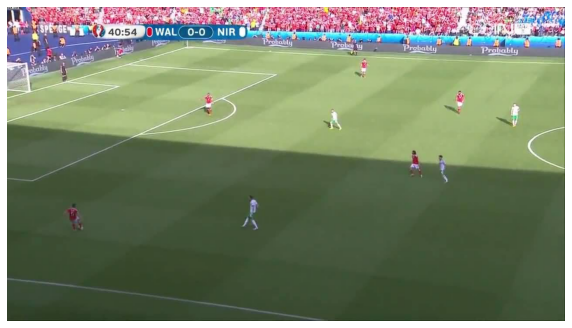

In [6]:
# plot of original image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image)

The approach of understanding the correct analysis of the frame involves previous knowledge about the samples selected. Below, there is a list of expected answers for each image of the small dataset of 50 inputs:
* 20.jpg - Team A: 5 players; Team B: 4 players
* 127.jpg - Team A: 6 players; Team B: 9 players
* 219.jpg - Team A: 8 players; Team B: 7 players
* 224.jpg - Team A: 8 players; Team B: 5 players
* 239.jpg - Team A: 5 players; Team B: 5 players
* 244.jpg - Team A: 7 players; Team B: 7 players
* 1021.jpg - Team A: 8 players; Team B: 6 players
* 1022.jpg - Team A: 8 players; Team B: 6 players
* 1025.jpg - Team A: 7 players; Team B: 7 players
* 1028.jpg - Team A: 5 to 6 players; Team B: 8 players
* 1045.jpg - Team A: 1 player; Team B: 3 players
* 1065.jpg - Team A: 8 players; Team B: 7 players
* 1082.jpg - Team A: 2 players; Team B: 3 players
* 1190.jpg - Team A: 6 players; Team B: 8 players
* 1223.jpg - Team A: 6 players; Team B: 3 players
* 1283.jpg - Team A: 6 to 7 players; Team B: 4 players
* 1304.jpg - Team A: 8 players; Team B: 7 players
* 1307.jpg - Team A: 6 players; Team B: 9 players
* 1362.jpg - Team A: 9 to 10 players; Team B: 10 players
* 1369.jpg - Team A: 8 to 9 players; Team B: 9 to 10 players
* 1384.jpg - Team A: 8 to 9 players; Team B: 7 to 8 players
* 1437.jpg - Team A: 7 players; Team B: 5 players
* 1533.jpg - Team A: 8 players; Team B: 6 players
* 1564.jpg - Team A: 6 to 7 players; Team B: 7 players
* 1602.jpg - Team A: 6 to 7 players; Team B: 8 players
* 1662.jpg - Team A: 4 players; Team B: 7 players
* 1683.jpg - Team A: 5 players; Team B: 9 players
* 1711.jpg - Team A: 7 players; Team B: 6 to 7 players
* 1719.jpg - Team A: 7 players; Team B: 6 to 7 players
* 1753.jpg - Team A: 7 players; Team B: 5 players
* 1756.jpg - Team A: 9 players; Team B: 7 players
* 1769.jpg - Team A: 5 players; Team B: 7 players
* 1796.jpg - Team A: 10 players; Team B: 9 players
* 1802.jpg - Team A: 6 to 7 players; Team B: 7 players
* 1850.jpg - Team A: 5 players; Team B: 6 players
* 1915.jpg - Team A: 7 players; Team B: 7 players
* 1937.jpg - Team A: 6 players; Team B: 7 to 8 players
* 1955.jpg - Team A: 8 players; Team B: 6 players
* 1966.jpg - Team A: 5 to 6 players; Team B: 7 players
* 1969.jpg - Team A: 3 to 5 players; Team B: 7 players
* 1981.jpg - Team A: 7 players; Team B: 7 to 8 players
* 2011.jpg - Team A: 2 to 4 players; Team B: 7 players
* 2021.jpg - Team A: 6 players; Team B: 7 players
* 2055.jpg - Team A: 8 to 9 players; Team B: 6 players
* 10321.jpg - Team A: 7 to 8 players; Team B: 10 players
* 14775.jpg - Team A: 8 players; Team B: 6 players
* 16678.jpg - Team A: 5 players; Team B: 5 to 6 players
* 18566.jpg - Team A: 10 players; Team B: 7 players
* 23269.jpg - Team A: 9 players; Team B: 6 players
* 24531.jpg - Team A: 3 players; Team B: 6 to 7 players

Inconclusive player counts (x to y players) rely on the situations were the frame could lead just to part of the body of the player, turning the definition of the presence of a player unstable to check.

As long as the analysis will also use color to distinguish the teams, the goalkeeper will be excluded from the count of the players. Team A and Tema B could vary in the output, according to the order of analysis, as long as attack and defense conditions are not defined.

### Preprocessing

A few techniques will be applied on the images for better understanding of the behavior of the descriptors that wiil be applied to get information about the amount of players displayed on the pitch. The path to be followed will rely in some tests:
* Debluring, if necessary;
* Conversion of RGB into only one of the channels: 
 * One of the colors (red, green or blue);
 * Greyscale image through luminance.


The first approach beneath the cited above will be prioritized in the study. The image above will be used as the example to go through the preproceesing step.

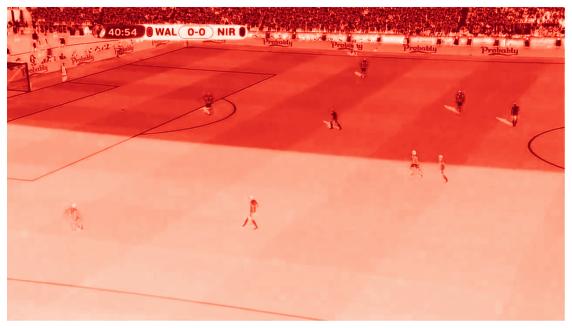

In [12]:
# one channel preprocessing - red

input_image_R = input_image[:,:,0].astype(float)
input_image_R = input_image_R.astype(np.uint8)



# plot of converted image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_R, cmap='Reds')

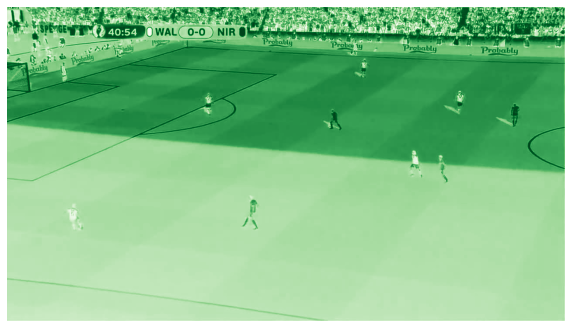

In [16]:
# one channel preprocessing - green

input_image_G = input_image[:,:,1].astype(float)
input_image_G = input_image_G.astype(np.uint8)


# plot of converted image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_G, cmap='Greens')

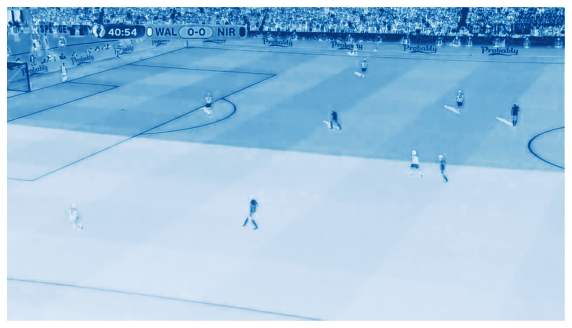

In [18]:
# one channel preprocessing - blue

input_image_B = input_image[:,:,2].astype(float)
input_image_B = input_image_B.astype(np.uint8)


# plot of converted image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_B, cmap='Blues')

Only in this example of the dataset, it is noticed that shadow can interfere in the player detection and could not be that effective to separate players of diffrent teams.

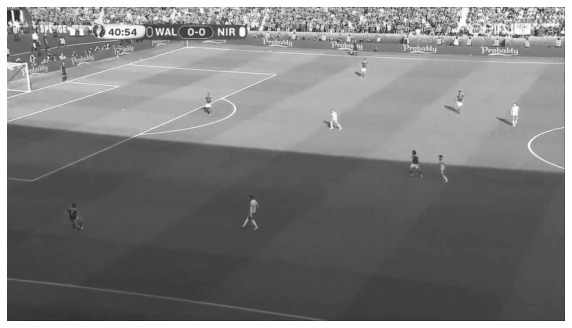

In [19]:
# greyscale preprocessing through luminance method

input_image_luminance = input_image.astype(float)
input_image_luminance = input_image_luminance[:,:,0]*0.3 + input_image_luminance[:,:,1]*0.59 + input_image_luminance[:,:,2]*0.11
input_image_luminance = input_image_luminance.astype(np.uint8)

# normalization
img_min = np.min(input_image_luminance)
img_max = np.max(input_image_luminance)
if (img_max - img_min != 0):
    input_image_luminance = (input_image_luminance - img_min)/(img_max-img_min)
    
# result
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(input_image_luminance, cmap = plt.get_cmap(name = 'gray'))

As long as the intention of the project is to check how many players are displayed in pitch and their separation between two teams, in the space domain, the conversion to greyscale, visually, has shown itself more effective to achieve these objectives.

### Bounding Boxes and Bag of Features

With the preprocessed images, the algorithm of the bag of features will be applied with the strategy of cutting the players of the original image through the descriptors.

After that, the Bag of Features will applied to obtain the descriptors.

The division strategy is to fit a player into the "texton". By this, patches would be 24x12, representing a rectangular shape that must contain the player. With this configuration, it must have a total of 3200 patches in the input image. 

(-0.5, 47.5, 95.5, -0.5)

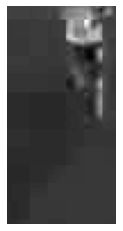

In [40]:
# separating image parts
patches = extract_patches_2d(input_image, 
                           patch_size=(96,48),
                           max_patches=3200, 
                           random_state=0)

# example of patch generated
plt.imshow(patches[190], cmap = plt.get_cmap(name = 'gray'))
plt.axis('off')

By this example of patch, it is possible to refine and find specific framing to get player as one of the image descriptors. This is the following step of the bag of features analysis 

In [43]:
lbp = feature.local_binary_pattern(input_image, 8, 1, method="uniform")

(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))

hist = hist.astype("float")
hist /= (hist.sum() + 1e-6)

In [44]:
hist

array([0.00881836, 0.0208214 , 0.01102865, 0.0420638 , 0.06521267,
       0.17196398, 0.02611762, 0.02647786, 0.57353624, 0.05395942])

Until now histogram is not conclusive.

### Desired Results

The results desired after the applying of the algorithms of the methodology is the information extraction from the match frame. The main metric to be obtained is the number of players of each team displayed in that fragment of the pitch, additional information important to be computed in case of successful approach is the attack/defence scenario description. 

## References

[1] Zanganeh, A., Jampour, M., Layeghi, K.: IAUFD: A 100k images dataset for automatic football image/video analysis. IET Image Process. 00, 1– 10 (2022). https://doi.org/10.1049/ipr2.12543
